# Car Racing

In [1]:
# # General
import platform
assert platform.python_version() == "3.10.14"
# !pip install 'gymnasium[box2d]'
# !pip install 'syne-tune[basic]'
# !pip install 'stable-baselines3[extra]'

## Hyperparameter Tuning

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from syne_tune import Tuner
from syne_tune.backend import PythonBackend
from syne_tune.experiments import load_experiment
from syne_tune.config_space import loguniform, uniform
from syne_tune.optimizer.baselines import ASHA
from syne_tune.stopping_criterion import StoppingCriterion

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/adavidho/Library/Application Support/sagemaker/config.yaml


In [3]:
# Define the hyperparameter search space
config_space = {
    "learning_rate": loguniform(1e-8, 0.1),
    "tau":  loguniform(1e-8, 1),
    "gamma": uniform(0.9, 0.999),    
    "steps": 100000 # TODO increase
}

In [4]:
# Define the tuning function
def train_hpo_model(learning_rate: float, tau: float, gamma: float, steps: int):
    # Worker imports
    import numpy as np
    from stable_baselines3.common.env_util import make_vec_env
    from stable_baselines3.common.evaluation import evaluate_policy
    from stable_baselines3.common.callbacks import BaseCallback
    from stable_baselines3.common.noise import NormalActionNoise
    from stable_baselines3 import TD3
    
    from syne_tune import Reporter

    # Create the vectorized environment
    env_id = "CarRacing-v2"
    vec_env = make_vec_env(env_id, n_envs=4)
    
    # Initialize the PPO agent with the given hyperparameters
    n_actions = vec_env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))  
    model = TD3("CnnPolicy", vec_env,  
                action_noise=action_noise,
                learning_rate=learning_rate,
                tau=tau,
                gamma=gamma,
                batch_size=32,
                verbose=1)

    report = Reporter()
    class WorkerCallback(BaseCallback):
        def _on_step(self) -> bool:
            # Log the mean reward
            mean_reward = sum(self.locals["rewards"]) / len(self.locals["rewards"])
            step = self.locals["num_collected_steps"]
            report(step=step, mean_reward=mean_reward)
            return True 
    
    # Train the agent
    worker_callback = WorkerCallback()
    model.learn(total_timesteps=steps, callback=worker_callback)

In [5]:
metric = "mean_reward"
scheduler = ASHA(
    config_space,
    metric=metric,
    max_resource_attr="steps",
    resource_attr="step",
    mode="max",
)
trial_backend = PythonBackend(
    tune_function=train_hpo_model, config_space=config_space
)
stop_criterion = StoppingCriterion(
    max_wallclock_time=1800, 
)
tuner = Tuner(
    trial_backend=trial_backend,
    scheduler=scheduler,
    stop_criterion=stop_criterion,
    n_workers=8,
    save_tuner=False,
    wait_trial_completion_when_stopping=True,
)

In [6]:
# Start hyperparameter tuning
tuner.run()

--------------------
Resource summary (last result is reported):
 trial_id    status  iter  learning_rate          tau    gamma  steps  step  mean_reward  worker-time
        0 Completed 25000   3.162278e-05 1.000000e-04 0.949500 100000     1    -0.100000  1534.029914
        1 Completed 25000   2.608652e-02 4.459980e-06 0.994957 100000     1    -0.100000  1483.139701
        2   Stopped    26   9.665928e-02 4.096052e-02 0.985687 100000     1     0.744595     1.622826
        3   Stopped    26   2.024949e-07 1.190156e-06 0.974795 100000     1    -0.100000     1.625575
        4 Completed 25000   9.361879e-07 2.460509e-03 0.950723 100000     1    -0.100000  1616.216955
        5 Completed 25000   3.572324e-07 4.242431e-04 0.929951 100000     1    -0.100000  1535.470439
        6   Stopped    26   2.245840e-02 4.473014e-08 0.937820 100000     1    -0.100000     1.642087
        7   Stopped    26   1.140124e-04 1.346816e-07 0.983634 100000     1    -0.100000     1.640366
        8 Complet

In [7]:
# Get results
tuner_path = tuner.tuner_path
tuning_experiment = load_experiment(tuner_path)
tuning_experiment.results.to_csv("tuning_results.csv")
tuning_experiment.best_config()


{'step': 1,
 'mean_reward': 7.686551213264465,
 'trial_id': 30,
 'config_learning_rate': 0.0006870666329035,
 'config_tau': 1.1701360615400289e-08,
 'config_gamma': 0.967562143466215,
 'config_steps': 100000}

In [5]:
# Read results dataframe
df = pd.read_csv("tuning_results.csv")

In [6]:
print("Number of tuning jobs:", len(df))
best_run = df.loc[df["mean_reward"].idxmax()]
print("Best mean reward:", round(best_run.mean_reward, 4))
print("Best tuning configuration:")
for i in ["config_learning_rate", "config_tau", "config_gamma"]:
    print(f" - {i}: {best_run[i]:.4e}")

Number of tuning jobs: 65004
Best mean reward: 8.0301
Best tuning configuration:
 - config_learning_rate: 5.6672e-05
 - config_tau: 7.2524e-06
 - config_gamma: 9.7588e-01


Text(0.5, 1.0, 'Mean Reward Histogram Across Configurations')

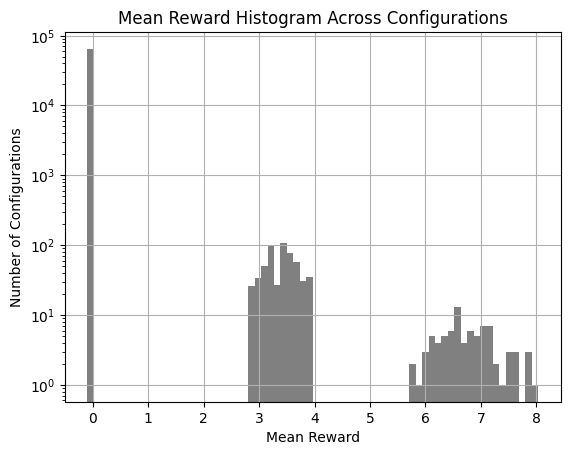

In [4]:
df.mean_reward.hist(bins=70, color = "grey")
plt.yscale('log')
plt.ylabel("Number of Configurations")
plt.xlabel("Mean Reward")
plt.title("Mean Reward Histogram Across Configurations")

From the above plot we can derive that most hyperparameter configurations have lead to rewards close to zero. A second cluster of configurations led to mean rewards between 2.7 and 4 and a final cluster to higher rewards between 5.6 and 8.1.

## Training

In [34]:
import numpy as np
import gymnasium as gym
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CheckpointCallback, CallbackList
from stable_baselines3 import TD3

In [35]:
# Create the vectorized environment
env_id = "CarRacing-v2"
log_dir = "./artifacts/"
env = gym.make(env_id, domain_randomize=False, render_mode="rgb_array") 
env = Monitor(env, log_dir, allow_early_resets=True)

In [36]:
# Initialize optimal hyperparameters
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))  
learning_rate = best_run.config_learning_rate
tau = best_run.config_tau
gamma = best_run.config_gamma
# Create the TD3 Agent
model = TD3(
    "CnnPolicy", 
    env,  
    action_noise=action_noise,
    learning_rate=learning_rate,
    tau=tau,
    gamma=gamma,
    batch_size=32,
    verbose=1,
    device="cuda"
)

Using cpu device
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/adavidho/anaconda3/envs/rl/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 55.32GB > 15.10GB
  warnings.warn(


In [37]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True

In [38]:
# Start training
time_steps = 5
model.learn(total_timesteps=time_steps, callback=callback)
model.save("artifacts/td3_car_racing")

In [39]:
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_EPISODES, "TD3 Training on Car Racing V2")
plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 800x200 with 0 Axes>

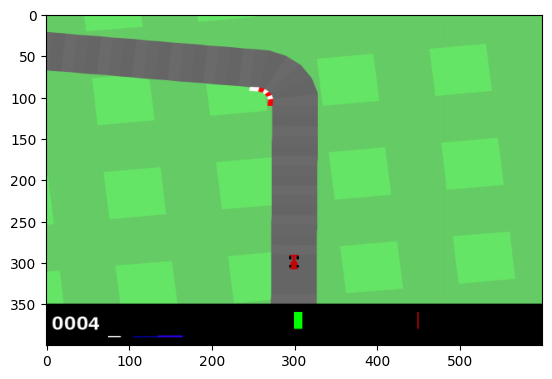

In [41]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
env = model.get_env()
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(20):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step([action])